In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, plot_mpl
init_notebook_mode(connected=True)

import numpy as np
import sklearn
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Problem 2

## Choose and critique one of the visualization by one of your fellow classmates for HW 1 Problem 2 (distribution of income across countries and continents over time). Include a link to the original.
<https://nbviewer.jupyter.org/github/fhooton/DS5500_HW1/blob/master/solutions.ipynb>

## Describe the visualization and how it is similar and/or different from yours. Is it easy to interpret? Does it effectively visualize what is being asked? Why or why not?
The visualization uses filled area plots. Viewer can easily see how GDP for each continent changes over time, and can also easily be used to compare the GDP differences between each continents. This is very different from mine which visualizes the geographical map directly. The method used in this visualization is more efficient for comparing the actual numbers over time, and effectively visualizes the question being asked. It, however, fails to visualize the data per country due to filled area plots are not effective in visualizing hundreds of groups.

# Problem 3

## Choose and critique one of the visualization by one of your fellow classmates for HW 1 Problem 3 (relationship between income, life expectancy, and child mortality over time). Include a link to the original.
<https://nbviewer.jupyter.org/github/fhooton/DS5500_HW1/blob/master/solutions.ipynb>

## Describe the visualization and how it is similar and/or different from yours. Is it easy to interpret? Does it effectively visualize what is being asked? Why or why not?
This visualization uses an interactive scatter plot with animation over time while using different colors for each continent. Mine uses static line plots. While mine is easy to visualize the trend of each continent over time, this visualization is much more effective for comparing data point for each country. Although the comparison between continent is slightly more difficult to interpret, due to each continent uses different color for each data points, it also enables viewers to further look into the actual distribution. The use of interactive plot makes detailed information for each data point(country) able to be further investigated based on researchers' interest. Overall I think this is a very effective visualization.

# Problem 4

## Choose and fit one or more models to quantify the relationship betweem income (GDP per capita) and life expectancy over time. Justify your choice of model and comment on its appropriateness. (You are not required to handle the autocorrelation of time series, but should comment on how this impacts your analysis.)

In [2]:
df_pop = pd.read_csv('dataset/ddf--gapminder--systema_globalis-master/ddf--datapoints--population_total--by--geo--time.csv')
df_gdp = pd.read_csv('dataset/ddf--gapminder--systema_globalis-master/ddf--datapoints--gdppercapita_us_inflation_adjusted--by--geo--time.csv')
df_life = pd.read_csv('dataset/ddf--gapminder--systema_globalis-master/ddf--datapoints--life_expectancy_years--by--geo--time.csv')
df_geo = pd.read_csv('dataset/ddf--gapminder--systema_globalis-master/ddf--entities--geo--country.csv')[['country', 'world_6region']]
df_geo = df_geo.rename(columns={'country': 'geo'})
#
df = df_pop.merge(df_gdp).merge(df_life).merge(df_geo)
df.describe()

time  population_total  gdppercapita_us_inflation_adjusted  \
count  8469.000000      8.469000e+03                         8469.000000   
mean   1992.300744      3.322621e+07                         9968.105362   
std      15.949795      1.218820e+08                        15212.309631   
min    1960.000000      2.427600e+04                          115.794140   
25%    1980.000000      2.045580e+06                         1083.284820   
50%    1994.000000      6.484452e+06                         3262.190580   
75%    2006.000000      2.115164e+07                        11546.822250   
max    2017.000000      1.409517e+09                       113682.038240   

       life_expectancy_years  
count            8469.000000  
mean               66.056859  
std                10.021248  
min                12.640000  
25%                58.700000  
50%                68.400000  
75%                73.910000  
max                84.030000

### visualize GDP vs Life Expectancy

In [3]:
fig = px.scatter(
    df,
    df.gdppercapita_us_inflation_adjusted.name,
    df.life_expectancy_years.name,
    animation_frame=df.time.name,
    color=df.world_6region.name,
    log_x=True,
    range_x=(min(df.gdppercapita_us_inflation_adjusted)*0.8,
             max(df.gdppercapita_us_inflation_adjusted)*1.2),
    range_y=(min(df.life_expectancy_years)*0.8,
             max(df.life_expectancy_years)*1.2),
    category_orders={df.time.name: sorted(set(df.time))})
fig.show()

correlation matrix

In [4]:
df.corr()

time  population_total  \
time                                1.000000          0.027753   
population_total                    0.027753          1.000000   
gdppercapita_us_inflation_adjusted  0.152992         -0.040021   
life_expectancy_years               0.425853          0.006734   

                                    gdppercapita_us_inflation_adjusted  \
time                                                          0.152992   
population_total                                             -0.040021   
gdppercapita_us_inflation_adjusted                            1.000000   
life_expectancy_years                                         0.578083   

                                    life_expectancy_years  
time                                             0.425853  
population_total                                 0.006734  
gdppercapita_us_inflation_adjusted               0.578083  
life_expectancy_years                            1.000000

### Linear Regression Analysis

In [5]:
df['log_gdp'] = np.log(df.gdppercapita_us_inflation_adjusted)
#
df_world = pd.get_dummies(df.world_6region)
df_world = df_world[df_world.columns[1:]]
#
df3 = df.join(df_world)

In [6]:
df3.columns

Index(['geo', 'time', 'population_total', 'gdppercapita_us_inflation_adjusted',
       'life_expectancy_years', 'world_6region', 'log_gdp',
       'east_asia_pacific', 'europe_central_asia', 'middle_east_north_africa',
       'south_asia', 'sub_saharan_africa'],
      dtype='object')

In [7]:
# train/test split
df_train = df3.sample(frac=0.8, random_state=5500)
df_test = df3.drop(df_train.index)

Fit Linear Model

In [8]:
Xcols = ['log_gdp', 'time'] + list(df_world.columns)
ycol = 'life_expectancy_years'

mod = sm.WLS(
    df_train[ycol],
    df_train[Xcols],
    weights=df_train.population_total
).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  WLS Regression Results                                  
==========================================================================================
Dep. Variable:     life_expectancy_years   R-squared (uncentered):                   0.995
Model:                               WLS   Adj. R-squared (uncentered):              0.995
Method:                    Least Squares   F-statistic:                          1.892e+05
Date:                   Wed, 23 Oct 2019   Prob (F-statistic):                        0.00
Time:                           20:36:05   Log-Likelihood:                         -26216.
No. Observations:                   6775   AIC:                                  5.245e+04
Df Residuals:                       6768   BIC:                                  5.249e+04
Df Model:                              7                                                  
Covariance Type:               nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
log_gdp                      4.5270      0.054     83.335      0.000       4.420       4.633
time                         0.0150      0.000     55.602      0.000       0.014       0.016
east_asia_pacific            4.5368      0.213     21.297      0.000       4.119       4.954
europe_central_asia          0.3874      0.226      1.715      0.086      -0.056       0.830
middle_east_north_africa     1.5805      0.320      4.942      0.000       0.954       2.207
south_asia                   0.4841      0.255      1.895      0.058      -0.017       0.985
sub_saharan_africa          -4.7208      0.280    -16.845      0.000      -5.270      -4.171
==============================================================================
Omnibus:                     7546.603   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2955409.323
Skew:                          -5.136   Prob(JB):                         0.00
Kurtosis:                     104.803   Cond. No.                     1.55e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
train_pred = mod.predict(df_train[Xcols])
train_mse = sklearn.metrics.mean_squared_error(train_pred, df_train[ycol], sample_weight=df_train.population_total)
test_pred = mod.predict(df_test[Xcols])
test_mse = sklearn.metrics.mean_squared_error(test_pred, df_test[ycol], sample_weight=df_test.population_total)

print('Train MSE: {}'.format(train_mse))
print('Test MSE: {}'.format(test_mse))

Train MSE: 22.828133881780452
Test MSE: 18.741618651717094


Error vs gdp

In [10]:
df_train['predict'] = mod.predict(df_train[Xcols])
df_train['error'] = df_train['predict'] - df_train[ycol]

In [11]:
fig = px.scatter(
    df_train,
    'log_gdp',
    'error',
    color='time',
    hover_name='geo',
    range_x=(min(df_train.log_gdp)*0.8,
             max(df_train.log_gdp)*1.2),
    range_y=(min(df_train.error)*1.2,
             max(df_train.error)*1.2),
    opacity=0.5,
    category_orders={df_train.time.name: sorted(set(df_train.time))},
)
fig.show()

In [12]:
fig = px.scatter(
    df_train,
    'log_gdp',
    'error',
    color='world_6region',
    hover_name='geo',
    range_x=(min(df_train.log_gdp)*0.8,
             max(df_train.log_gdp)*1.2),
    range_y=(min(df_train.error)*1.2,
             max(df_train.error)*1.2),
    opacity=0.5,
    category_orders={df_train.time.name: sorted(set(df_train.time))},
)
fig.show()

In [13]:
fig = px.scatter(
    df_train,
    'gdppercapita_us_inflation_adjusted',
    'error',
    animation_frame=df.time.name,
    color=df.world_6region.name,
    log_x=True,
    hover_name='geo',
    range_x=(min(df_train.gdppercapita_us_inflation_adjusted)*0.8,
             max(df_train.gdppercapita_us_inflation_adjusted)*1.2),
    range_y=(min(df_train.error)*1.2,
             max(df_train.error)*1.2),
    marginal_y='violin',
    category_orders={df_train.time.name: sorted(set(df_train.time))})
fig.show()

QQ plot

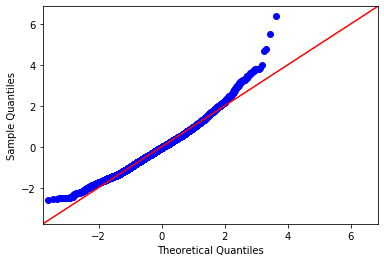

In [14]:
sm.qqplot(df_train.error, fit=True, line='45')
plt.show()

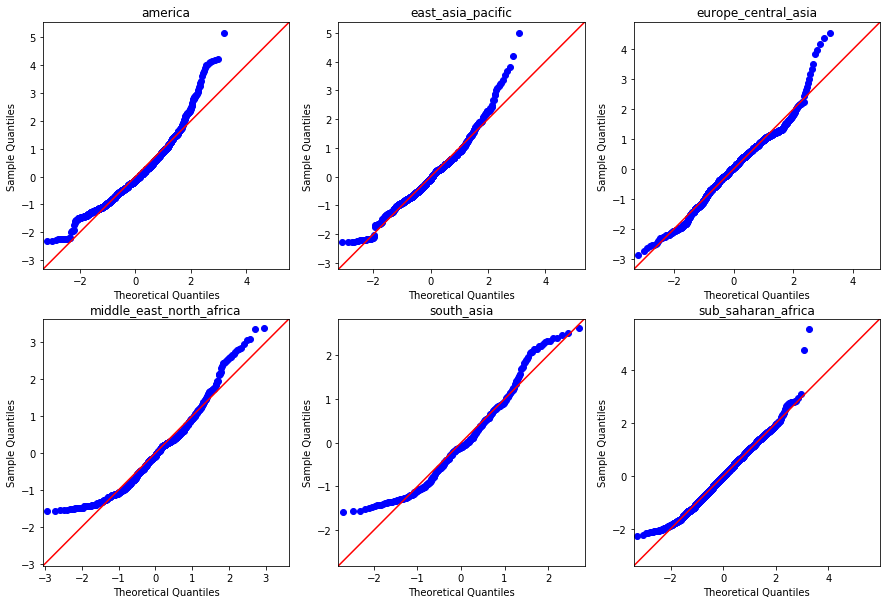

In [15]:
N, M = 2, 3
fig, axes = plt.subplots(N, M)
fig.set_size_inches(15, 10)
for i, region in enumerate(sorted(set(df_train.world_6region))):
    df_region = df_train[df_train.world_6region == region]
    ax = axes[i//M,i%M]
    ax.title.set_text(region)
    sm.qqplot(df_region['error'], fit=True, line='45', ax=ax)
plt.show()

I have used Linear Regression Analysis to analyze the relationship of GDP vs Life Expectancy. According to R-squared, Adjusted R-squared, QQ-plot this is a reasonable tool for investigating the relationship between the given variables. In this analysis I have used Year as a continuous variable; this choice might have negatively affect the analysis since the affect of Year might not have equal affect on each consecutive years.

## Visualize the model(s) and comment on what they tell you about the relationship between income and life expectancy over time.

In [16]:
', '.join(Xcols)

'log_gdp, time, east_asia_pacific, europe_central_asia, middle_east_north_africa, south_asia, sub_saharan_africa'

In [17]:
times = sorted(set(df.time))
region= ['america' for _ in times]
log_gdp = [0 for _ in times]

X_vis = [(0, t, 0, 0, 0, 0, 0) for t in times]
pred = mod.predict(X_vis)
df_vis = pd.DataFrame({
    'time': times,
    'pred': pred
})

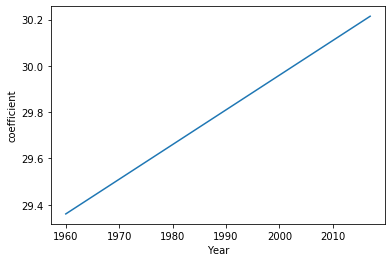

In [18]:
plt.plot(times, pred)
plt.xlabel('Year')
plt.ylabel('coefficient')
plt.show()

Since I am using linear regression with using time as linear continuous variable, the affect of time for the relationship between income and life expectancy is linear. Life expectancy have become higher for the same income level over time. Time having positive affect on life expectancy has statistical significance for the p-value < 0.05.

# Problem 5

## Choose and fit one or more models to quantify the relationship betweem income (GDP per capita) and child mortality over time. Justify your choice of model and comment on its appropriateness. (You are not required to handle the autocorrelation of time series, but should comment on how this impacts your analysis.)

In [19]:
df_pop = pd.read_csv('dataset/ddf--gapminder--systema_globalis-master/ddf--datapoints--population_total--by--geo--time.csv')
df_gdp = pd.read_csv('dataset/ddf--gapminder--systema_globalis-master/ddf--datapoints--gdppercapita_us_inflation_adjusted--by--geo--time.csv')
df_mort = pd.read_csv('dataset/ddf--gapminder--systema_globalis-master/ddf--datapoints--child_mortality_0_5_year_olds_dying_per_1000_born--by--geo--time.csv')
df_geo = pd.read_csv('dataset/ddf--gapminder--systema_globalis-master/ddf--entities--geo--country.csv')[['country', 'world_6region']]
df_geo = df_geo.rename(columns={'country': 'geo'})
#
df = df_pop.merge(df_gdp).merge(df_mort).merge(df_geo).rename(columns={
    'gdppercapita_us_inflation_adjusted': 'gdp',
    'child_mortality_0_5_year_olds_dying_per_1000_born': 'mort'})

### visualize GDP vs Child Mortality

In [20]:
df['log_gdp'] = np.log(df.gdp)
df['log_mort'] = np.log(df.mort)
fig = px.scatter(
    df,
    'log_gdp',
    'log_mort',
    animation_frame=df.time.name,
    color='world_6region',
    range_x=(min(df.log_gdp)*0.8,
             max(df.log_gdp)*1.2),
    range_y=(min(df.log_mort)*0.8,
             max(df.log_mort)*1.2),
    category_orders={df.time.name: sorted(set(df.time))})
fig.show()

In [21]:
df.corr()

time  population_total       gdp      mort   log_gdp  \
time              1.000000          0.024779  0.161036 -0.484042  0.173554   
population_total  0.024779          1.000000 -0.040518 -0.010961 -0.079683   
gdp               0.161036         -0.040518  1.000000 -0.453164  0.801715   
mort             -0.484042         -0.010961 -0.453164  1.000000 -0.706759   
log_gdp           0.173554         -0.079683  0.801715 -0.706759  1.000000   
log_mort         -0.480284          0.018686 -0.679564  0.871395 -0.830201   

                  log_mort  
time             -0.480284  
population_total  0.018686  
gdp              -0.679564  
mort              0.871395  
log_gdp          -0.830201  
log_mort          1.000000

### Linear Regression Analysis

In [22]:
df_world = pd.get_dummies(df.world_6region)
df_world = df_world[df_world.columns[1:]]
#
df3 = df.join(df_world)

In [23]:
df_train = df3.sample(frac=0.8, random_state=5500)
df_test = df3.drop(df_train.index)

Fit Linear Model

In [24]:
Xcols = ['log_gdp', 'time'] + list(df_world.columns)
ycol = 'log_mort'
mod = sm.WLS(
    df_train[ycol],
    df_train[Xcols],
    weights=df_train.population_total
).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                
=======================================================================================
Dep. Variable:               log_mort   R-squared (uncentered):                   0.982
Model:                            WLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                          5.376e+04
Date:                Wed, 23 Oct 2019   Prob (F-statistic):                        0.00
Time:                        20:36:28   Log-Likelihood:                         -11547.
No. Observations:                6854   AIC:                                  2.311e+04
Df Residuals:                    6847   BIC:                                  2.316e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
log_gdp                     -0.6110      0.006   -100.495      0.000      -0.623      -0.599
time                         0.0045   2.99e-05    149.684      0.000       0.004       0.005
east_asia_pacific           -0.7957      0.024    -33.563      0.000      -0.842      -0.749
europe_central_asia         -0.5498      0.025    -22.044      0.000      -0.599      -0.501
middle_east_north_africa    -0.0827      0.035     -2.343      0.019      -0.152      -0.013
south_asia                  -0.3143      0.028    -11.251      0.000      -0.369      -0.259
sub_saharan_africa           0.0874      0.031      2.850      0.004       0.027       0.148
==============================================================================
Omnibus:                     1164.642   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8373.723
Skew:                           0.621   Prob(JB):                         0.00
Kurtosis:                       8.271   Cond. No.                     1.56e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
train_pred = mod.predict(df_train[Xcols])
train_mse = sklearn.metrics.mean_squared_error(train_pred, df_train[ycol], sample_weight=df_train.population_total)
test_pred = mod.predict(df_test[Xcols])
test_mse = sklearn.metrics.mean_squared_error(test_pred, df_test[ycol], sample_weight=df_test.population_total)

print('Train MSE: {}'.format(train_mse))
print('Test MSE: {}'.format(test_mse))

Train MSE: 0.27996047463972407
Test MSE: 0.2720294884042084


Error vs gdp

In [26]:
df_train['predict'] = mod.predict(df_train[Xcols])
df_train['error'] = df_train['predict'] - df_train[ycol]

In [27]:
fig = px.scatter(
    df_train,
    'log_gdp',
    'error',
    color='time',
    opacity=0.5,
)
fig.show()

In [28]:
fig = px.scatter(
    df_train,
    'log_gdp',
    'error',
    color='world_6region',
    opacity=0.5,
)
fig.show()

In [ ]:
fig = px.scatter(
    df_train,
    'log_gdp',
    'error',
    animation_frame='time',
    color='world_6region',
    range_x=(min(df_train.log_gdp)*0.8,
             max(df_train.log_gdp)*1.2),
    range_y=(min(df_train.error)*1.2,
             max(df_train.error)*1.2),
    category_orders={df_train.time.name: sorted(set(df_train.time))}
)
fig.show()

QQ plot

In [ ]:
sm.qqplot(df_train.error, fit=True, line='45')
plt.show()

In [ ]:
N, M = 2, 3
fig, axes = plt.subplots(N, M)
fig.set_size_inches(15, 10)
for i, region in enumerate(sorted(set(df_train.world_6region))):
    df_region = df_train[df_train.world_6region == region]
    ax = axes[i//M,i%M]
    ax.title.set_text(region)
    sm.qqplot(df_region['error'], fit=True, line='45', ax=ax)
plt.show()

I have used Linear Regression Analysis to analyze the relationship of GDP vs Child Mortality. According to R-squared, Adjusted R-squared, QQ-plot this is a reasonable tool for investigating the relationship between the given variables. In this analysis I have used Year as a continuous variable; this choice might have negatively affect the analysis since the affect of Year might not have equal affect on each consecutive years.

## Visualize the model(s) and comment on what they tell you about the relationship between income and child mortality over time.

In [ ]:
', '.join(Xcols)

In [ ]:
times = sorted(set(df.time))
region= ['america' for _ in times]
log_gdp = [0 for _ in times]

X_vis = [(0, t, 0, 0, 0, 0, 0) for t in times]
pred = mod.predict(X_vis)
df_vis = pd.DataFrame({
    'time': times,
    'pred': pred
})

In [ ]:
plt.plot(times, pred)
plt.xlabel('Year')
plt.ylabel('coefficient')
plt.show()

Since I am using linear regression with using time as linear continuous variable, the affect of time for the relationship between income and child mortality is linear. Child mortality have become higher for the same income level over time. Time having positive affect on life expectancy has statistical significance for the p-value < 0.05. This does not mean that child mortality have been increasing in more recent years due to generally the income level of each country have been increased in recent years. Also note that based on my linear regression analysis, GDP has negative effect on child mortality.